This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
custom_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/custom_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
custom_aggregated_data_pca = pd.read_parquet(custom_aggregated_data_pca_path)
print(custom_aggregated_data_pca.shape)
custom_aggregated_data_pca.head()

(83, 86)


,Metadata_genotype,Metadata_replicate,Metadata_side,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
0,High-Severity,1,L,-5.798417,3.829101,0.235508,-1.891659,0.269128,-9.286478,0.547681,...,-0.139746,-0.028435,-0.108986,-0.061343,0.107011,0.070422,0.098300,0.014989,-0.047070,3.680084e-15
1,High-Severity,1,R,-0.147725,-7.333535,-1.375084,-1.299879,-1.557402,2.658578,-3.362463,...,0.589385,-0.512889,-0.181329,-0.033345,0.105213,0.181050,0.098753,0.059413,-0.146195,-7.507207e-16
2,High-Severity,10,L,4.244648,-10.919777,-2.979601,-2.539290,0.374291,4.635479,0.642153,...,0.040760,0.119014,0.649102,0.140987,0.034728,0.078310,-0.177995,-0.188239,-0.270704,-9.132831e-17
3,High-Severity,10,R,1.115032,-5.931238,-2.604917,0.476947,-0.520816,3.033154,-2.047205,...,-0.536821,-0.319381,0.253793,0.032361,-0.058072,-0.538296,-0.421887,0.068166,0.085418,1.085143e-16
4,High-Severity,11,L,0.485280,-8.943044,0.981028,-0.914526,0.630209,-6.363313,0.711778,...,-0.066315,-0.109219,0.183489,0.048739,-0.056860,-0.120726,0.008437,-0.003078,-0.014906,9.784586e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

28 27 28


In [4]:
# drop the the Metadata columns
metadata_columns = high_severity.columns[high_severity.columns.str.contains("Metadata")]
high_severity = high_severity.drop(metadata_columns, axis=1)
low_severity = low_severity.drop(metadata_columns, axis=1)
wt = wt.drop(metadata_columns, axis=1)


# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(28, 83) (27, 83) (28, 83)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 18.401314906445336


/home/lippincm/miniforge3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 10.855720066737538


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 12.4934895144469


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                            | 0/1000 [00:00<?, ?it/s]

  0%|                                                    | 1/1000 [00:00<05:39,  2.94it/s]

  0%|                                                    | 2/1000 [00:00<04:40,  3.55it/s]

  0%|▏                                                   | 3/1000 [00:00<03:58,  4.18it/s]

  0%|▏                                                   | 4/1000 [00:01<04:01,  4.12it/s]

  0%|▎                                                   | 5/1000 [00:01<05:11,  3.19it/s]

  1%|▎                                                   | 6/1000 [00:01<05:19,  3.11it/s]

  1%|▎                                                   | 7/1000 [00:02<05:01,  3.30it/s]

  1%|▍                                                   | 8/1000 [00:02<04:21,  3.80it/s]

  1%|▍                                                   | 9/1000 [00:02<06:23,  2.58it/s]

  1%|▌                                                  | 10/1000 [00:03<08:12,  2.01it/s]

  1%|▌                                                  | 11/1000 [00:04<09:18,  1.77it/s]

  1%|▌                                                  | 12/1000 [00:04<08:46,  1.88it/s]

  1%|▋                                                  | 13/1000 [00:05<09:09,  1.80it/s]

  1%|▋                                                  | 14/1000 [00:06<09:28,  1.73it/s]

  2%|▊                                                  | 15/1000 [00:06<07:31,  2.18it/s]

  2%|▊                                                  | 16/1000 [00:06<07:12,  2.27it/s]

  2%|▊                                                  | 17/1000 [00:07<09:36,  1.70it/s]

  2%|▉                                                  | 18/1000 [00:08<09:30,  1.72it/s]

  2%|▉                                                  | 19/1000 [00:08<10:22,  1.58it/s]

  2%|█                                                  | 20/1000 [00:10<12:44,  1.28it/s]

  2%|█                                                  | 21/1000 [00:10<09:53,  1.65it/s]

  2%|█                                                  | 22/1000 [00:10<09:44,  1.67it/s]

  2%|█▏                                                 | 23/1000 [00:11<12:05,  1.35it/s]

  2%|█▏                                                 | 24/1000 [00:12<13:11,  1.23it/s]

  2%|█▎                                                 | 25/1000 [00:13<13:51,  1.17it/s]

  3%|█▎                                                 | 26/1000 [00:14<12:25,  1.31it/s]

  3%|█▍                                                 | 27/1000 [00:14<10:35,  1.53it/s]

  3%|█▍                                                 | 28/1000 [00:15<11:33,  1.40it/s]

  3%|█▍                                                 | 29/1000 [00:16<12:50,  1.26it/s]

  3%|█▌                                                 | 30/1000 [00:17<11:46,  1.37it/s]

  3%|█▌                                                 | 31/1000 [00:17<10:00,  1.61it/s]

  3%|█▋                                                 | 32/1000 [00:17<07:49,  2.06it/s]

  3%|█▋                                                 | 33/1000 [00:18<07:13,  2.23it/s]

  3%|█▋                                                 | 34/1000 [00:18<09:27,  1.70it/s]

  4%|█▊                                                 | 35/1000 [00:19<11:27,  1.40it/s]

  4%|█▊                                                 | 36/1000 [00:20<12:48,  1.25it/s]

  4%|█▉                                                 | 37/1000 [00:21<13:29,  1.19it/s]

  4%|█▉                                                 | 38/1000 [00:22<11:24,  1.41it/s]

  4%|█▉                                                 | 39/1000 [00:22<09:17,  1.72it/s]

  4%|██                                                 | 40/1000 [00:22<07:27,  2.15it/s]

  4%|██                                                 | 41/1000 [00:23<07:04,  2.26it/s]

  4%|██▏                                                | 42/1000 [00:23<08:12,  1.95it/s]

  4%|██▏                                                | 43/1000 [00:24<09:08,  1.75it/s]

  4%|██▏                                                | 44/1000 [00:25<09:33,  1.67it/s]

  4%|██▎                                                | 45/1000 [00:25<07:55,  2.01it/s]

  5%|██▎                                                | 46/1000 [00:26<09:06,  1.74it/s]

  5%|██▍                                                | 47/1000 [00:26<09:42,  1.64it/s]

  5%|██▍                                                | 48/1000 [00:27<10:00,  1.58it/s]

  5%|██▍                                                | 49/1000 [00:27<08:46,  1.81it/s]

  5%|██▌                                                | 50/1000 [00:28<08:32,  1.85it/s]

  5%|██▌                                                | 51/1000 [00:29<09:53,  1.60it/s]

  5%|██▋                                                | 52/1000 [00:29<08:58,  1.76it/s]

  5%|██▋                                                | 53/1000 [00:30<07:54,  1.99it/s]

  5%|██▊                                                | 54/1000 [00:30<06:42,  2.35it/s]

  6%|██▊                                                | 55/1000 [00:30<07:11,  2.19it/s]

  6%|██▊                                                | 56/1000 [00:31<06:58,  2.25it/s]

  6%|██▉                                                | 57/1000 [00:32<10:07,  1.55it/s]

  6%|██▉                                                | 58/1000 [00:32<08:55,  1.76it/s]

  6%|███                                                | 59/1000 [00:32<07:04,  2.22it/s]

  6%|███                                                | 60/1000 [00:33<06:01,  2.60it/s]

  6%|███                                                | 61/1000 [00:33<06:55,  2.26it/s]

  6%|███▏                                               | 62/1000 [00:34<07:37,  2.05it/s]

  6%|███▏                                               | 63/1000 [00:34<07:38,  2.04it/s]

  6%|███▎                                               | 64/1000 [00:35<08:26,  1.85it/s]

  6%|███▎                                               | 65/1000 [00:36<08:06,  1.92it/s]

  7%|███▎                                               | 66/1000 [00:36<09:19,  1.67it/s]

  7%|███▍                                               | 67/1000 [00:37<09:40,  1.61it/s]

  7%|███▍                                               | 68/1000 [00:37<08:14,  1.88it/s]

  7%|███▌                                               | 69/1000 [00:38<07:09,  2.17it/s]

  7%|███▌                                               | 70/1000 [00:38<07:53,  1.96it/s]

  7%|███▌                                               | 71/1000 [00:39<08:46,  1.77it/s]

  7%|███▋                                               | 72/1000 [00:40<09:12,  1.68it/s]

  7%|███▋                                               | 73/1000 [00:40<08:00,  1.93it/s]

  7%|███▊                                               | 74/1000 [00:41<09:44,  1.58it/s]

  8%|███▊                                               | 75/1000 [00:41<07:44,  1.99it/s]

  8%|███▉                                               | 76/1000 [00:41<06:38,  2.32it/s]

  8%|███▉                                               | 77/1000 [00:42<06:50,  2.25it/s]

  8%|███▉                                               | 78/1000 [00:43<09:28,  1.62it/s]

  8%|████                                               | 79/1000 [00:43<09:52,  1.55it/s]

  8%|████                                               | 80/1000 [00:44<10:42,  1.43it/s]

  8%|████▏                                              | 81/1000 [00:44<08:27,  1.81it/s]

  8%|████▏                                              | 82/1000 [00:45<07:51,  1.95it/s]

  8%|████▏                                              | 83/1000 [00:46<08:10,  1.87it/s]

  8%|████▎                                              | 84/1000 [00:46<07:11,  2.12it/s]

  8%|████▎                                              | 85/1000 [00:47<08:22,  1.82it/s]

  9%|████▍                                              | 86/1000 [00:48<11:16,  1.35it/s]

  9%|████▍                                              | 87/1000 [00:48<09:54,  1.54it/s]

  9%|████▍                                              | 88/1000 [00:49<08:52,  1.71it/s]

  9%|████▌                                              | 89/1000 [00:50<10:41,  1.42it/s]

  9%|████▌                                              | 90/1000 [00:50<10:46,  1.41it/s]

  9%|████▋                                              | 91/1000 [00:51<09:32,  1.59it/s]

  9%|████▋                                              | 92/1000 [00:51<08:53,  1.70it/s]

  9%|████▋                                              | 93/1000 [00:51<07:11,  2.10it/s]

  9%|████▊                                              | 94/1000 [00:52<06:33,  2.30it/s]

 10%|████▊                                              | 95/1000 [00:52<07:18,  2.06it/s]

 10%|████▉                                              | 96/1000 [00:53<07:30,  2.01it/s]

 10%|████▉                                              | 97/1000 [00:54<08:41,  1.73it/s]

 10%|████▉                                              | 98/1000 [00:54<09:12,  1.63it/s]

 10%|█████                                              | 99/1000 [00:55<09:18,  1.61it/s]

 10%|█████                                             | 100/1000 [00:56<08:42,  1.72it/s]

 10%|█████                                             | 101/1000 [00:56<07:36,  1.97it/s]

 10%|█████                                             | 102/1000 [00:57<08:53,  1.68it/s]

 10%|█████▏                                            | 103/1000 [00:57<09:19,  1.60it/s]

 10%|█████▏                                            | 104/1000 [00:58<10:00,  1.49it/s]

 10%|█████▎                                            | 105/1000 [00:58<08:10,  1.83it/s]

 11%|█████▎                                            | 106/1000 [00:59<09:40,  1.54it/s]

 11%|█████▎                                            | 107/1000 [01:00<08:18,  1.79it/s]

 11%|█████▍                                            | 108/1000 [01:00<09:27,  1.57it/s]

 11%|█████▍                                            | 109/1000 [01:01<10:17,  1.44it/s]

 11%|█████▌                                            | 110/1000 [01:02<09:56,  1.49it/s]

 11%|█████▌                                            | 111/1000 [01:02<08:41,  1.70it/s]

 11%|█████▌                                            | 112/1000 [01:03<09:41,  1.53it/s]

 11%|█████▋                                            | 113/1000 [01:04<08:47,  1.68it/s]

 11%|█████▋                                            | 114/1000 [01:04<10:05,  1.46it/s]

 12%|█████▊                                            | 115/1000 [01:05<10:26,  1.41it/s]

 12%|█████▊                                            | 116/1000 [01:06<10:09,  1.45it/s]

 12%|█████▊                                            | 117/1000 [01:06<08:11,  1.80it/s]

 12%|█████▉                                            | 118/1000 [01:07<09:17,  1.58it/s]

 12%|█████▉                                            | 119/1000 [01:08<09:46,  1.50it/s]

 12%|██████                                            | 120/1000 [01:08<07:38,  1.92it/s]

 12%|██████                                            | 121/1000 [01:09<08:23,  1.74it/s]

 12%|██████                                            | 122/1000 [01:09<09:45,  1.50it/s]

 12%|██████▏                                           | 123/1000 [01:10<09:45,  1.50it/s]

 12%|██████▏                                           | 124/1000 [01:10<08:27,  1.72it/s]

 12%|██████▎                                           | 125/1000 [01:11<08:55,  1.63it/s]

 13%|██████▎                                           | 126/1000 [01:12<08:49,  1.65it/s]

 13%|██████▎                                           | 127/1000 [01:13<09:34,  1.52it/s]

 13%|██████▍                                           | 128/1000 [01:13<10:21,  1.40it/s]

 13%|██████▍                                           | 129/1000 [01:14<09:26,  1.54it/s]

 13%|██████▌                                           | 130/1000 [01:15<09:47,  1.48it/s]

 13%|██████▌                                           | 131/1000 [01:15<10:17,  1.41it/s]

 13%|██████▌                                           | 132/1000 [01:16<09:42,  1.49it/s]

 13%|██████▋                                           | 133/1000 [01:17<10:11,  1.42it/s]

 13%|██████▋                                           | 134/1000 [01:18<10:57,  1.32it/s]

 14%|██████▊                                           | 135/1000 [01:18<09:21,  1.54it/s]

 14%|██████▊                                           | 136/1000 [01:19<09:26,  1.52it/s]

 14%|██████▊                                           | 137/1000 [01:19<08:21,  1.72it/s]

 14%|██████▉                                           | 138/1000 [01:19<07:22,  1.95it/s]

 14%|██████▉                                           | 139/1000 [01:20<06:17,  2.28it/s]

 14%|███████                                           | 140/1000 [01:20<05:10,  2.77it/s]

 14%|███████                                           | 141/1000 [01:21<06:39,  2.15it/s]

 14%|███████                                           | 142/1000 [01:21<06:23,  2.24it/s]

 14%|███████▏                                          | 143/1000 [01:22<08:05,  1.77it/s]

 14%|███████▏                                          | 144/1000 [01:23<10:18,  1.39it/s]

 14%|███████▏                                          | 145/1000 [01:24<11:08,  1.28it/s]

 15%|███████▎                                          | 146/1000 [01:24<08:55,  1.59it/s]

 15%|███████▎                                          | 147/1000 [01:24<07:17,  1.95it/s]

 15%|███████▍                                          | 148/1000 [01:25<08:23,  1.69it/s]

 15%|███████▍                                          | 149/1000 [01:26<10:30,  1.35it/s]

 15%|███████▌                                          | 150/1000 [01:27<11:09,  1.27it/s]

 15%|███████▌                                          | 151/1000 [01:28<11:31,  1.23it/s]

 15%|███████▌                                          | 152/1000 [01:28<09:16,  1.52it/s]

 15%|███████▋                                          | 153/1000 [01:29<09:29,  1.49it/s]

 15%|███████▋                                          | 154/1000 [01:30<11:02,  1.28it/s]

 16%|███████▊                                          | 155/1000 [01:31<12:05,  1.16it/s]

 16%|███████▊                                          | 156/1000 [01:32<11:40,  1.20it/s]

 16%|███████▊                                          | 157/1000 [01:32<10:43,  1.31it/s]

 16%|███████▉                                          | 158/1000 [01:33<10:19,  1.36it/s]

 16%|███████▉                                          | 159/1000 [01:34<10:05,  1.39it/s]

 16%|████████                                          | 160/1000 [01:35<12:18,  1.14it/s]

 16%|████████                                          | 161/1000 [01:36<10:42,  1.31it/s]

 16%|████████                                          | 162/1000 [01:36<10:12,  1.37it/s]

 16%|████████▏                                         | 163/1000 [01:38<13:55,  1.00it/s]

 16%|████████▏                                         | 164/1000 [01:39<13:02,  1.07it/s]

 16%|████████▎                                         | 165/1000 [01:39<11:50,  1.17it/s]

 17%|████████▎                                         | 166/1000 [01:39<09:00,  1.54it/s]

 17%|████████▎                                         | 167/1000 [01:40<07:02,  1.97it/s]

 17%|████████▍                                         | 168/1000 [01:40<05:56,  2.33it/s]

 17%|████████▍                                         | 169/1000 [01:40<04:53,  2.83it/s]

 17%|████████▌                                         | 170/1000 [01:40<04:29,  3.08it/s]

 17%|████████▌                                         | 171/1000 [01:41<04:11,  3.29it/s]

 17%|████████▌                                         | 172/1000 [01:41<03:58,  3.48it/s]

 17%|████████▋                                         | 173/1000 [01:41<03:39,  3.78it/s]

 17%|████████▋                                         | 174/1000 [01:41<03:22,  4.07it/s]

 18%|████████▊                                         | 175/1000 [01:41<03:09,  4.35it/s]

 18%|████████▊                                         | 176/1000 [01:42<02:56,  4.68it/s]

 18%|████████▊                                         | 177/1000 [01:42<02:53,  4.75it/s]

 18%|████████▉                                         | 178/1000 [01:42<02:45,  4.98it/s]

 18%|████████▉                                         | 179/1000 [01:42<02:39,  5.15it/s]

 18%|█████████                                         | 180/1000 [01:42<02:34,  5.32it/s]

 18%|█████████                                         | 181/1000 [01:43<02:37,  5.21it/s]

 18%|█████████                                         | 182/1000 [01:43<03:04,  4.43it/s]

 18%|█████████▏                                        | 183/1000 [01:43<03:22,  4.03it/s]

 18%|█████████▏                                        | 184/1000 [01:43<03:04,  4.42it/s]

 18%|█████████▎                                        | 185/1000 [01:43<02:51,  4.76it/s]

 19%|█████████▎                                        | 186/1000 [01:44<02:42,  5.02it/s]

 19%|█████████▎                                        | 187/1000 [01:44<03:14,  4.17it/s]

 19%|█████████▍                                        | 188/1000 [01:44<03:08,  4.30it/s]

 19%|█████████▍                                        | 189/1000 [01:44<02:54,  4.65it/s]

 19%|█████████▌                                        | 190/1000 [01:45<02:43,  4.95it/s]

 19%|█████████▌                                        | 191/1000 [01:45<02:36,  5.17it/s]

 19%|█████████▌                                        | 192/1000 [01:45<02:32,  5.30it/s]

 19%|█████████▋                                        | 193/1000 [01:45<02:30,  5.38it/s]

 19%|█████████▋                                        | 194/1000 [01:45<02:27,  5.47it/s]

 20%|█████████▊                                        | 195/1000 [01:45<02:32,  5.29it/s]

 20%|█████████▊                                        | 196/1000 [01:46<02:42,  4.96it/s]

 20%|█████████▊                                        | 197/1000 [01:46<02:36,  5.13it/s]

 20%|█████████▉                                        | 198/1000 [01:46<02:49,  4.72it/s]

 20%|█████████▉                                        | 199/1000 [01:47<03:50,  3.47it/s]

 20%|██████████                                        | 200/1000 [01:47<04:12,  3.17it/s]

 20%|██████████                                        | 201/1000 [01:47<04:21,  3.05it/s]

 20%|██████████                                        | 202/1000 [01:48<03:44,  3.55it/s]

 20%|██████████▏                                       | 203/1000 [01:48<03:18,  4.01it/s]

 20%|██████████▏                                       | 204/1000 [01:48<03:01,  4.38it/s]

 20%|██████████▎                                       | 205/1000 [01:48<02:48,  4.70it/s]

 21%|██████████▎                                       | 206/1000 [01:48<03:03,  4.33it/s]

 21%|██████████▎                                       | 207/1000 [01:49<03:12,  4.11it/s]

 21%|██████████▍                                       | 208/1000 [01:49<03:14,  4.08it/s]

 21%|██████████▍                                       | 209/1000 [01:49<02:58,  4.44it/s]

 21%|██████████▌                                       | 210/1000 [01:49<03:06,  4.23it/s]

 21%|██████████▌                                       | 211/1000 [01:50<03:44,  3.52it/s]

 21%|██████████▌                                       | 212/1000 [01:50<03:17,  3.98it/s]

 21%|██████████▋                                       | 213/1000 [01:50<03:07,  4.21it/s]

 21%|██████████▋                                       | 214/1000 [01:50<02:57,  4.42it/s]

 22%|██████████▊                                       | 215/1000 [01:50<02:47,  4.69it/s]

 22%|██████████▊                                       | 216/1000 [01:51<02:58,  4.39it/s]

 22%|██████████▊                                       | 217/1000 [01:51<03:28,  3.76it/s]

 22%|██████████▉                                       | 218/1000 [01:51<03:28,  3.76it/s]

 22%|██████████▉                                       | 219/1000 [01:52<03:31,  3.69it/s]

 22%|███████████                                       | 220/1000 [01:52<03:27,  3.77it/s]

 22%|███████████                                       | 221/1000 [01:52<03:27,  3.75it/s]

 22%|███████████                                       | 222/1000 [01:52<03:06,  4.16it/s]

 22%|███████████▏                                      | 223/1000 [01:53<03:34,  3.63it/s]

 22%|███████████▏                                      | 224/1000 [01:53<03:27,  3.74it/s]

 22%|███████████▎                                      | 225/1000 [01:53<03:49,  3.37it/s]

 23%|███████████▎                                      | 226/1000 [01:54<03:47,  3.40it/s]

 23%|███████████▎                                      | 227/1000 [01:54<03:56,  3.27it/s]

 23%|███████████▍                                      | 228/1000 [01:54<03:45,  3.42it/s]

 23%|███████████▍                                      | 229/1000 [01:54<03:46,  3.40it/s]

 23%|███████████▌                                      | 230/1000 [01:55<03:35,  3.57it/s]

 23%|███████████▌                                      | 231/1000 [01:55<03:11,  4.02it/s]

 23%|███████████▌                                      | 232/1000 [01:55<02:53,  4.42it/s]

 23%|███████████▋                                      | 233/1000 [01:55<03:08,  4.08it/s]

 23%|███████████▋                                      | 234/1000 [01:56<02:57,  4.31it/s]

 24%|███████████▊                                      | 235/1000 [01:56<03:06,  4.09it/s]

 24%|███████████▊                                      | 236/1000 [01:56<02:58,  4.28it/s]

 24%|███████████▊                                      | 237/1000 [01:56<02:53,  4.40it/s]

 24%|███████████▉                                      | 238/1000 [01:56<02:40,  4.73it/s]

 24%|███████████▉                                      | 239/1000 [01:57<03:07,  4.06it/s]

 24%|████████████                                      | 240/1000 [01:57<02:50,  4.46it/s]

 24%|████████████                                      | 241/1000 [01:57<03:37,  3.50it/s]

 24%|████████████                                      | 242/1000 [01:58<03:39,  3.45it/s]

 24%|████████████▏                                     | 243/1000 [01:58<03:44,  3.37it/s]

 24%|████████████▏                                     | 244/1000 [01:58<03:15,  3.87it/s]

 24%|████████████▎                                     | 245/1000 [01:58<03:14,  3.88it/s]

 25%|████████████▎                                     | 246/1000 [01:59<03:19,  3.78it/s]

 25%|████████████▎                                     | 247/1000 [01:59<03:28,  3.61it/s]

 25%|████████████▍                                     | 248/1000 [01:59<03:17,  3.80it/s]

 25%|████████████▍                                     | 249/1000 [01:59<02:59,  4.19it/s]

 25%|████████████▌                                     | 250/1000 [02:00<03:09,  3.96it/s]

 25%|████████████▌                                     | 251/1000 [02:00<02:59,  4.17it/s]

 25%|████████████▌                                     | 252/1000 [02:00<02:44,  4.55it/s]

 25%|████████████▋                                     | 253/1000 [02:00<02:48,  4.43it/s]

 25%|████████████▋                                     | 254/1000 [02:00<02:35,  4.81it/s]

 26%|████████████▊                                     | 255/1000 [02:01<02:45,  4.50it/s]

 26%|████████████▊                                     | 256/1000 [02:01<02:49,  4.38it/s]

 26%|████████████▊                                     | 257/1000 [02:01<03:02,  4.08it/s]

 26%|████████████▉                                     | 258/1000 [02:02<03:16,  3.77it/s]

 26%|████████████▉                                     | 259/1000 [02:02<02:56,  4.20it/s]

 26%|█████████████                                     | 260/1000 [02:02<02:59,  4.13it/s]

 26%|█████████████                                     | 261/1000 [02:02<03:00,  4.09it/s]

 26%|█████████████                                     | 262/1000 [02:02<02:45,  4.47it/s]

 26%|█████████████▏                                    | 263/1000 [02:03<02:50,  4.33it/s]

 26%|█████████████▏                                    | 264/1000 [02:03<03:58,  3.08it/s]

 26%|█████████████▎                                    | 265/1000 [02:03<03:30,  3.49it/s]

 27%|█████████████▎                                    | 266/1000 [02:04<03:06,  3.94it/s]

 27%|█████████████▎                                    | 267/1000 [02:04<03:19,  3.67it/s]

 27%|█████████████▍                                    | 268/1000 [02:04<03:34,  3.41it/s]

 27%|█████████████▍                                    | 269/1000 [02:05<03:33,  3.42it/s]

 27%|█████████████▌                                    | 270/1000 [02:05<03:10,  3.84it/s]

 27%|█████████████▌                                    | 271/1000 [02:05<03:08,  3.86it/s]

 27%|█████████████▌                                    | 272/1000 [02:05<03:08,  3.86it/s]

 27%|█████████████▋                                    | 273/1000 [02:05<02:49,  4.28it/s]

 27%|█████████████▋                                    | 274/1000 [02:06<02:37,  4.61it/s]

 28%|█████████████▊                                    | 275/1000 [02:06<02:30,  4.82it/s]

 28%|█████████████▊                                    | 276/1000 [02:06<02:23,  5.05it/s]

 28%|█████████████▊                                    | 277/1000 [02:06<02:18,  5.22it/s]

 28%|█████████████▉                                    | 278/1000 [02:06<02:14,  5.35it/s]

 28%|█████████████▉                                    | 279/1000 [02:07<02:44,  4.39it/s]

 28%|██████████████                                    | 280/1000 [02:07<03:16,  3.67it/s]

 28%|██████████████                                    | 281/1000 [02:07<03:20,  3.58it/s]

 28%|██████████████                                    | 282/1000 [02:07<02:58,  4.03it/s]

 28%|██████████████▏                                   | 283/1000 [02:08<02:42,  4.41it/s]

 28%|██████████████▏                                   | 284/1000 [02:08<02:33,  4.67it/s]

 28%|██████████████▏                                   | 285/1000 [02:08<02:40,  4.45it/s]

 29%|██████████████▎                                   | 286/1000 [02:08<02:45,  4.33it/s]

 29%|██████████████▎                                   | 287/1000 [02:09<02:48,  4.24it/s]

 29%|██████████████▍                                   | 288/1000 [02:09<02:57,  4.02it/s]

 29%|██████████████▍                                   | 289/1000 [02:09<02:43,  4.34it/s]

 29%|██████████████▍                                   | 290/1000 [02:09<02:31,  4.67it/s]

 29%|██████████████▌                                   | 291/1000 [02:10<03:08,  3.75it/s]

 29%|██████████████▌                                   | 292/1000 [02:10<02:55,  4.04it/s]

 29%|██████████████▋                                   | 293/1000 [02:10<02:40,  4.41it/s]

 29%|██████████████▋                                   | 294/1000 [02:10<02:29,  4.74it/s]

 30%|██████████████▊                                   | 295/1000 [02:11<03:01,  3.88it/s]

 30%|██████████████▊                                   | 296/1000 [02:11<03:01,  3.87it/s]

 30%|██████████████▊                                   | 297/1000 [02:11<02:46,  4.23it/s]

 30%|██████████████▉                                   | 298/1000 [02:11<03:22,  3.47it/s]

 30%|██████████████▉                                   | 299/1000 [02:12<03:07,  3.73it/s]

 30%|███████████████                                   | 300/1000 [02:12<03:02,  3.84it/s]

 30%|███████████████                                   | 301/1000 [02:12<03:25,  3.41it/s]

 30%|███████████████                                   | 302/1000 [02:12<03:22,  3.45it/s]

 30%|███████████████▏                                  | 303/1000 [02:13<03:00,  3.87it/s]

 30%|███████████████▏                                  | 304/1000 [02:13<02:42,  4.28it/s]

 30%|███████████████▎                                  | 305/1000 [02:13<02:41,  4.31it/s]

 31%|███████████████▎                                  | 306/1000 [02:13<02:53,  4.01it/s]

 31%|███████████████▎                                  | 307/1000 [02:14<02:59,  3.85it/s]

 31%|███████████████▍                                  | 308/1000 [02:14<02:58,  3.88it/s]

 31%|███████████████▍                                  | 309/1000 [02:14<02:41,  4.28it/s]

 31%|███████████████▌                                  | 310/1000 [02:14<02:29,  4.62it/s]

 31%|███████████████▌                                  | 311/1000 [02:15<02:41,  4.26it/s]

 31%|███████████████▌                                  | 312/1000 [02:15<02:30,  4.58it/s]

 31%|███████████████▋                                  | 313/1000 [02:15<02:46,  4.12it/s]

 31%|███████████████▋                                  | 314/1000 [02:15<02:45,  4.14it/s]

 32%|███████████████▊                                  | 315/1000 [02:15<02:37,  4.36it/s]

 32%|███████████████▊                                  | 316/1000 [02:16<02:25,  4.70it/s]

 32%|███████████████▊                                  | 317/1000 [02:16<02:18,  4.94it/s]

 32%|███████████████▉                                  | 318/1000 [02:16<02:13,  5.09it/s]

 32%|███████████████▉                                  | 319/1000 [02:16<02:14,  5.06it/s]

 32%|████████████████                                  | 320/1000 [02:16<02:09,  5.23it/s]

 32%|████████████████                                  | 321/1000 [02:17<02:06,  5.35it/s]

 32%|████████████████                                  | 322/1000 [02:17<02:04,  5.45it/s]

 32%|████████████████▏                                 | 323/1000 [02:17<02:08,  5.26it/s]

 32%|████████████████▏                                 | 324/1000 [02:17<02:05,  5.40it/s]

 32%|████████████████▎                                 | 325/1000 [02:17<02:03,  5.48it/s]

 33%|████████████████▎                                 | 326/1000 [02:18<02:21,  4.76it/s]

 33%|████████████████▎                                 | 327/1000 [02:18<02:22,  4.71it/s]

 33%|████████████████▍                                 | 328/1000 [02:18<02:31,  4.45it/s]

 33%|████████████████▍                                 | 329/1000 [02:18<03:24,  3.28it/s]

 33%|████████████████▌                                 | 330/1000 [02:19<03:04,  3.63it/s]

 33%|████████████████▌                                 | 331/1000 [02:19<02:47,  3.99it/s]

 33%|████████████████▌                                 | 332/1000 [02:19<02:31,  4.40it/s]

 33%|████████████████▋                                 | 333/1000 [02:19<02:21,  4.71it/s]

 33%|████████████████▋                                 | 334/1000 [02:19<02:30,  4.43it/s]

 34%|████████████████▊                                 | 335/1000 [02:20<02:19,  4.77it/s]

 34%|████████████████▊                                 | 336/1000 [02:20<02:27,  4.49it/s]

 34%|████████████████▊                                 | 337/1000 [02:20<02:38,  4.18it/s]

 34%|████████████████▉                                 | 338/1000 [02:21<03:06,  3.55it/s]

 34%|████████████████▉                                 | 339/1000 [02:21<03:02,  3.62it/s]

 34%|█████████████████                                 | 340/1000 [02:21<02:44,  4.02it/s]

 34%|█████████████████                                 | 341/1000 [02:21<03:05,  3.56it/s]

 34%|█████████████████                                 | 342/1000 [02:22<02:44,  4.01it/s]

 34%|█████████████████▏                                | 343/1000 [02:22<02:36,  4.19it/s]

 34%|█████████████████▏                                | 344/1000 [02:22<02:45,  3.97it/s]

 34%|█████████████████▎                                | 345/1000 [02:22<02:44,  3.98it/s]

 35%|█████████████████▎                                | 346/1000 [02:22<02:29,  4.39it/s]

 35%|█████████████████▎                                | 347/1000 [02:23<02:32,  4.28it/s]

 35%|█████████████████▍                                | 348/1000 [02:23<02:21,  4.62it/s]

 35%|█████████████████▍                                | 349/1000 [02:23<02:13,  4.87it/s]

 35%|█████████████████▌                                | 350/1000 [02:23<02:30,  4.31it/s]

 35%|█████████████████▌                                | 351/1000 [02:24<02:32,  4.25it/s]

 35%|█████████████████▌                                | 352/1000 [02:24<02:22,  4.55it/s]

 35%|█████████████████▋                                | 353/1000 [02:24<02:13,  4.85it/s]

 35%|█████████████████▋                                | 354/1000 [02:24<02:07,  5.08it/s]

 36%|█████████████████▊                                | 355/1000 [02:25<02:40,  4.02it/s]

 36%|█████████████████▊                                | 356/1000 [02:25<02:58,  3.60it/s]

 36%|█████████████████▊                                | 357/1000 [02:25<02:38,  4.06it/s]

 36%|█████████████████▉                                | 358/1000 [02:25<02:27,  4.35it/s]

 36%|█████████████████▉                                | 359/1000 [02:25<02:16,  4.69it/s]

 36%|██████████████████                                | 360/1000 [02:26<02:42,  3.94it/s]

 36%|██████████████████                                | 361/1000 [02:26<02:36,  4.09it/s]

 36%|██████████████████                                | 362/1000 [02:26<02:37,  4.04it/s]

 36%|██████████████████▏                               | 363/1000 [02:26<02:37,  4.05it/s]

 36%|██████████████████▏                               | 364/1000 [02:27<02:23,  4.42it/s]

 36%|██████████████████▎                               | 365/1000 [02:27<02:30,  4.21it/s]

 37%|██████████████████▎                               | 366/1000 [02:27<02:35,  4.08it/s]

 37%|██████████████████▎                               | 367/1000 [02:27<02:40,  3.95it/s]

 37%|██████████████████▍                               | 368/1000 [02:28<02:29,  4.22it/s]

 37%|██████████████████▍                               | 369/1000 [02:28<02:17,  4.58it/s]

 37%|██████████████████▌                               | 370/1000 [02:28<02:22,  4.41it/s]

 37%|██████████████████▌                               | 371/1000 [02:28<02:37,  4.01it/s]

 37%|██████████████████▌                               | 372/1000 [02:29<02:38,  3.96it/s]

 37%|██████████████████▋                               | 373/1000 [02:29<02:24,  4.35it/s]

 37%|██████████████████▋                               | 374/1000 [02:29<02:30,  4.17it/s]

 38%|██████████████████▊                               | 375/1000 [02:29<03:02,  3.43it/s]

 38%|██████████████████▊                               | 376/1000 [02:30<02:39,  3.92it/s]

 38%|██████████████████▊                               | 377/1000 [02:30<02:23,  4.33it/s]

 38%|██████████████████▉                               | 378/1000 [02:30<02:14,  4.64it/s]

 38%|██████████████████▉                               | 379/1000 [02:30<02:07,  4.89it/s]

 38%|███████████████████                               | 380/1000 [02:30<02:15,  4.58it/s]

 38%|███████████████████                               | 381/1000 [02:31<02:31,  4.08it/s]

 38%|███████████████████                               | 382/1000 [02:31<03:07,  3.29it/s]

 38%|███████████████████▏                              | 383/1000 [02:32<03:46,  2.72it/s]

 38%|███████████████████▏                              | 384/1000 [02:32<04:02,  2.54it/s]

 38%|███████████████████▎                              | 385/1000 [02:32<03:37,  2.82it/s]

 39%|███████████████████▎                              | 386/1000 [02:33<03:19,  3.08it/s]

 39%|███████████████████▎                              | 387/1000 [02:33<02:54,  3.52it/s]

 39%|███████████████████▍                              | 388/1000 [02:33<03:10,  3.21it/s]

 39%|███████████████████▍                              | 389/1000 [02:33<02:46,  3.67it/s]

 39%|███████████████████▌                              | 390/1000 [02:34<02:28,  4.10it/s]

 39%|███████████████████▌                              | 391/1000 [02:34<02:15,  4.48it/s]

 39%|███████████████████▌                              | 392/1000 [02:34<02:06,  4.80it/s]

 39%|███████████████████▋                              | 393/1000 [02:34<02:00,  5.03it/s]

 39%|███████████████████▋                              | 394/1000 [02:34<01:58,  5.10it/s]

 40%|███████████████████▊                              | 395/1000 [02:35<02:07,  4.73it/s]

 40%|███████████████████▊                              | 396/1000 [02:35<02:01,  4.97it/s]

 40%|███████████████████▊                              | 397/1000 [02:35<02:16,  4.40it/s]

 40%|███████████████████▉                              | 398/1000 [02:35<02:40,  3.74it/s]

 40%|███████████████████▉                              | 399/1000 [02:36<02:34,  3.89it/s]

 40%|████████████████████                              | 400/1000 [02:36<02:18,  4.34it/s]

 40%|████████████████████                              | 401/1000 [02:36<02:20,  4.25it/s]

 40%|████████████████████                              | 402/1000 [02:36<02:09,  4.61it/s]

 40%|████████████████████▏                             | 403/1000 [02:37<02:29,  4.01it/s]

 40%|████████████████████▏                             | 404/1000 [02:37<02:24,  4.12it/s]

 40%|████████████████████▎                             | 405/1000 [02:37<02:35,  3.83it/s]

 41%|████████████████████▎                             | 406/1000 [02:37<02:55,  3.39it/s]

 41%|████████████████████▎                             | 407/1000 [02:38<03:05,  3.20it/s]

 41%|████████████████████▍                             | 408/1000 [02:38<02:52,  3.42it/s]

 41%|████████████████████▍                             | 409/1000 [02:38<02:36,  3.77it/s]

 41%|████████████████████▌                             | 410/1000 [02:38<02:20,  4.19it/s]

 41%|████████████████████▌                             | 411/1000 [02:39<02:09,  4.55it/s]

 41%|████████████████████▌                             | 412/1000 [02:39<02:26,  4.01it/s]

 41%|████████████████████▋                             | 413/1000 [02:39<02:31,  3.89it/s]

 41%|████████████████████▋                             | 414/1000 [02:40<02:54,  3.36it/s]

 42%|████████████████████▊                             | 415/1000 [02:40<03:06,  3.14it/s]

 42%|████████████████████▊                             | 416/1000 [02:40<03:06,  3.14it/s]

 42%|████████████████████▊                             | 417/1000 [02:41<03:05,  3.15it/s]

 42%|████████████████████▉                             | 418/1000 [02:41<03:01,  3.20it/s]

 42%|████████████████████▉                             | 419/1000 [02:41<02:37,  3.69it/s]

 42%|█████████████████████                             | 420/1000 [02:41<02:20,  4.13it/s]

 42%|█████████████████████                             | 421/1000 [02:41<02:08,  4.51it/s]

 42%|█████████████████████                             | 422/1000 [02:42<02:31,  3.81it/s]

 42%|█████████████████████▏                            | 423/1000 [02:42<02:17,  4.19it/s]

 42%|█████████████████████▏                            | 424/1000 [02:42<02:39,  3.61it/s]

 42%|█████████████████████▎                            | 425/1000 [02:43<02:29,  3.85it/s]

 43%|█████████████████████▎                            | 426/1000 [02:43<02:19,  4.12it/s]

 43%|█████████████████████▎                            | 427/1000 [02:43<02:35,  3.68it/s]

 43%|█████████████████████▍                            | 428/1000 [02:43<02:18,  4.12it/s]

 43%|█████████████████████▍                            | 429/1000 [02:44<02:22,  4.02it/s]

 43%|█████████████████████▌                            | 430/1000 [02:44<02:08,  4.42it/s]

 43%|█████████████████████▌                            | 431/1000 [02:44<02:25,  3.92it/s]

 43%|█████████████████████▌                            | 432/1000 [02:44<02:32,  3.73it/s]

 43%|█████████████████████▋                            | 433/1000 [02:45<02:45,  3.43it/s]

 43%|█████████████████████▋                            | 434/1000 [02:45<02:40,  3.52it/s]

 44%|█████████████████████▊                            | 435/1000 [02:45<02:22,  3.97it/s]

 44%|█████████████████████▊                            | 436/1000 [02:45<02:22,  3.97it/s]

 44%|█████████████████████▊                            | 437/1000 [02:46<02:12,  4.24it/s]

 44%|█████████████████████▉                            | 438/1000 [02:46<02:16,  4.13it/s]

 44%|█████████████████████▉                            | 439/1000 [02:46<02:16,  4.10it/s]

 44%|██████████████████████                            | 440/1000 [02:46<02:18,  4.05it/s]

 44%|██████████████████████                            | 441/1000 [02:46<02:05,  4.45it/s]

 44%|██████████████████████                            | 442/1000 [02:47<02:10,  4.27it/s]

 44%|██████████████████████▏                           | 443/1000 [02:47<02:04,  4.46it/s]

 44%|██████████████████████▏                           | 444/1000 [02:47<02:39,  3.49it/s]

 44%|██████████████████████▎                           | 445/1000 [02:48<02:23,  3.88it/s]

 45%|██████████████████████▎                           | 446/1000 [02:48<02:22,  3.89it/s]

 45%|██████████████████████▎                           | 447/1000 [02:48<02:19,  3.97it/s]

 45%|██████████████████████▍                           | 448/1000 [02:48<02:32,  3.61it/s]

 45%|██████████████████████▍                           | 449/1000 [02:49<02:20,  3.91it/s]

 45%|██████████████████████▌                           | 450/1000 [02:49<02:07,  4.32it/s]

 45%|██████████████████████▌                           | 451/1000 [02:49<02:04,  4.40it/s]

 45%|██████████████████████▌                           | 452/1000 [02:49<01:56,  4.72it/s]

 45%|██████████████████████▋                           | 453/1000 [02:49<01:54,  4.76it/s]

 45%|██████████████████████▋                           | 454/1000 [02:50<01:53,  4.83it/s]

 46%|██████████████████████▊                           | 455/1000 [02:50<01:50,  4.93it/s]

 46%|██████████████████████▊                           | 456/1000 [02:50<01:47,  5.05it/s]

 46%|██████████████████████▊                           | 457/1000 [02:50<02:02,  4.44it/s]

 46%|██████████████████████▉                           | 458/1000 [02:50<01:53,  4.77it/s]

 46%|██████████████████████▉                           | 459/1000 [02:51<01:47,  5.03it/s]

 46%|███████████████████████                           | 460/1000 [02:51<01:55,  4.68it/s]

 46%|███████████████████████                           | 461/1000 [02:51<02:04,  4.33it/s]

 46%|███████████████████████                           | 462/1000 [02:51<01:55,  4.65it/s]

 46%|███████████████████████▏                          | 463/1000 [02:51<01:49,  4.92it/s]

 46%|███████████████████████▏                          | 464/1000 [02:52<02:09,  4.13it/s]

 46%|███████████████████████▎                          | 465/1000 [02:52<01:59,  4.48it/s]

 47%|███████████████████████▎                          | 466/1000 [02:52<01:51,  4.80it/s]

 47%|███████████████████████▎                          | 467/1000 [02:52<01:45,  5.05it/s]

 47%|███████████████████████▍                          | 468/1000 [02:53<01:46,  4.99it/s]

 47%|███████████████████████▍                          | 469/1000 [02:53<02:08,  4.15it/s]

 47%|███████████████████████▌                          | 470/1000 [02:53<02:10,  4.05it/s]

 47%|███████████████████████▌                          | 471/1000 [02:53<02:07,  4.14it/s]

 47%|███████████████████████▌                          | 472/1000 [02:54<01:56,  4.52it/s]

 47%|███████████████████████▋                          | 473/1000 [02:54<01:49,  4.82it/s]

 47%|███████████████████████▋                          | 474/1000 [02:54<01:43,  5.06it/s]

 48%|███████████████████████▊                          | 475/1000 [02:54<01:40,  5.23it/s]

 48%|███████████████████████▊                          | 476/1000 [02:54<01:48,  4.84it/s]

 48%|███████████████████████▊                          | 477/1000 [02:55<01:56,  4.48it/s]

 48%|███████████████████████▉                          | 478/1000 [02:55<02:01,  4.30it/s]

 48%|███████████████████████▉                          | 479/1000 [02:55<02:21,  3.67it/s]

 48%|████████████████████████                          | 480/1000 [02:56<02:51,  3.04it/s]

 48%|████████████████████████                          | 481/1000 [02:56<02:52,  3.00it/s]

 48%|████████████████████████                          | 482/1000 [02:56<02:37,  3.28it/s]

 48%|████████████████████████▏                         | 483/1000 [02:56<02:26,  3.52it/s]

 48%|████████████████████████▏                         | 484/1000 [02:57<02:40,  3.22it/s]

 48%|████████████████████████▎                         | 485/1000 [02:57<02:21,  3.64it/s]

 49%|████████████████████████▎                         | 486/1000 [02:57<02:16,  3.77it/s]

 49%|████████████████████████▎                         | 487/1000 [02:58<02:13,  3.84it/s]

 49%|████████████████████████▍                         | 488/1000 [02:58<02:06,  4.03it/s]

 49%|████████████████████████▍                         | 489/1000 [02:58<01:56,  4.39it/s]

 49%|████████████████████████▌                         | 490/1000 [02:58<01:59,  4.26it/s]

 49%|████████████████████████▌                         | 491/1000 [02:58<01:53,  4.50it/s]

 49%|████████████████████████▌                         | 492/1000 [02:59<01:46,  4.78it/s]

 49%|████████████████████████▋                         | 493/1000 [02:59<02:21,  3.59it/s]

 49%|████████████████████████▋                         | 494/1000 [02:59<02:07,  3.98it/s]

 50%|████████████████████████▊                         | 495/1000 [02:59<01:59,  4.24it/s]

 50%|████████████████████████▊                         | 496/1000 [03:00<01:50,  4.56it/s]

 50%|████████████████████████▊                         | 497/1000 [03:00<02:01,  4.15it/s]

 50%|████████████████████████▉                         | 498/1000 [03:00<02:03,  4.07it/s]

 50%|████████████████████████▉                         | 499/1000 [03:00<02:09,  3.86it/s]

 50%|█████████████████████████                         | 500/1000 [03:01<01:57,  4.27it/s]

 50%|█████████████████████████                         | 501/1000 [03:01<01:52,  4.42it/s]

 50%|█████████████████████████                         | 502/1000 [03:01<01:57,  4.24it/s]

 50%|█████████████████████████▏                        | 503/1000 [03:01<01:56,  4.26it/s]

 50%|█████████████████████████▏                        | 504/1000 [03:01<01:56,  4.25it/s]

 50%|█████████████████████████▎                        | 505/1000 [03:02<02:06,  3.92it/s]

 51%|█████████████████████████▎                        | 506/1000 [03:02<02:12,  3.73it/s]

 51%|█████████████████████████▎                        | 507/1000 [03:02<02:09,  3.81it/s]

 51%|█████████████████████████▍                        | 508/1000 [03:03<02:26,  3.36it/s]

 51%|█████████████████████████▍                        | 509/1000 [03:03<02:09,  3.79it/s]

 51%|█████████████████████████▌                        | 510/1000 [03:03<01:57,  4.16it/s]

 51%|█████████████████████████▌                        | 511/1000 [03:03<01:48,  4.51it/s]

 51%|█████████████████████████▌                        | 512/1000 [03:04<04:11,  1.94it/s]

 51%|█████████████████████████▋                        | 513/1000 [03:05<03:58,  2.04it/s]

 51%|█████████████████████████▋                        | 514/1000 [03:06<05:16,  1.54it/s]

 52%|█████████████████████████▊                        | 515/1000 [03:06<04:53,  1.65it/s]

 52%|█████████████████████████▊                        | 516/1000 [03:07<03:53,  2.07it/s]

 52%|█████████████████████████▊                        | 517/1000 [03:07<03:17,  2.44it/s]

 52%|█████████████████████████▉                        | 518/1000 [03:07<03:15,  2.46it/s]

 52%|█████████████████████████▉                        | 519/1000 [03:08<03:05,  2.59it/s]

 52%|██████████████████████████                        | 520/1000 [03:08<03:46,  2.12it/s]

 52%|██████████████████████████                        | 521/1000 [03:09<04:48,  1.66it/s]

 52%|██████████████████████████                        | 522/1000 [03:10<05:35,  1.43it/s]

 52%|██████████████████████████▏                       | 523/1000 [03:11<06:49,  1.17it/s]

 52%|██████████████████████████▏                       | 524/1000 [03:12<05:19,  1.49it/s]

 52%|██████████████████████████▎                       | 525/1000 [03:12<04:08,  1.91it/s]

 53%|██████████████████████████▎                       | 526/1000 [03:12<03:25,  2.31it/s]

 53%|██████████████████████████▎                       | 527/1000 [03:12<02:56,  2.68it/s]

 53%|██████████████████████████▍                       | 528/1000 [03:13<02:49,  2.78it/s]

 53%|██████████████████████████▍                       | 529/1000 [03:13<03:06,  2.52it/s]

 53%|██████████████████████████▌                       | 530/1000 [03:13<02:47,  2.81it/s]

 53%|██████████████████████████▌                       | 531/1000 [03:13<02:23,  3.27it/s]

 53%|██████████████████████████▌                       | 532/1000 [03:14<02:20,  3.32it/s]

 53%|██████████████████████████▋                       | 533/1000 [03:14<02:09,  3.60it/s]

 53%|██████████████████████████▋                       | 534/1000 [03:14<01:59,  3.89it/s]

 54%|██████████████████████████▊                       | 535/1000 [03:15<02:26,  3.17it/s]

 54%|██████████████████████████▊                       | 536/1000 [03:15<02:15,  3.41it/s]

 54%|██████████████████████████▊                       | 537/1000 [03:15<02:03,  3.76it/s]

 54%|██████████████████████████▉                       | 538/1000 [03:16<02:51,  2.70it/s]

 54%|██████████████████████████▉                       | 539/1000 [03:17<03:52,  1.98it/s]

 54%|███████████████████████████                       | 540/1000 [03:17<03:55,  1.95it/s]

 54%|███████████████████████████                       | 541/1000 [03:17<03:18,  2.31it/s]

 54%|███████████████████████████                       | 542/1000 [03:18<03:32,  2.16it/s]

 54%|███████████████████████████▏                      | 543/1000 [03:19<04:13,  1.80it/s]

 54%|███████████████████████████▏                      | 544/1000 [03:19<04:27,  1.71it/s]

 55%|███████████████████████████▎                      | 545/1000 [03:20<03:49,  1.98it/s]

 55%|███████████████████████████▎                      | 546/1000 [03:20<03:05,  2.45it/s]

 55%|███████████████████████████▎                      | 547/1000 [03:20<02:33,  2.96it/s]

 55%|███████████████████████████▍                      | 548/1000 [03:20<02:28,  3.05it/s]

 55%|███████████████████████████▍                      | 549/1000 [03:21<03:09,  2.38it/s]

 55%|███████████████████████████▌                      | 550/1000 [03:21<03:05,  2.43it/s]

 55%|███████████████████████████▌                      | 551/1000 [03:22<04:11,  1.78it/s]

 55%|███████████████████████████▌                      | 552/1000 [03:23<05:38,  1.32it/s]

 55%|███████████████████████████▋                      | 553/1000 [03:24<04:48,  1.55it/s]

 55%|███████████████████████████▋                      | 554/1000 [03:24<03:44,  1.98it/s]

 56%|███████████████████████████▊                      | 555/1000 [03:24<03:00,  2.47it/s]

 56%|███████████████████████████▊                      | 556/1000 [03:24<02:46,  2.66it/s]

 56%|███████████████████████████▊                      | 557/1000 [03:25<03:26,  2.14it/s]

 56%|███████████████████████████▉                      | 558/1000 [03:26<04:37,  1.59it/s]

 56%|███████████████████████████▉                      | 559/1000 [03:27<04:30,  1.63it/s]

 56%|████████████████████████████                      | 560/1000 [03:28<05:30,  1.33it/s]

 56%|████████████████████████████                      | 561/1000 [03:28<04:54,  1.49it/s]

 56%|████████████████████████████                      | 562/1000 [03:28<03:59,  1.83it/s]

 56%|████████████████████████████▏                     | 563/1000 [03:29<03:33,  2.05it/s]

 56%|████████████████████████████▏                     | 564/1000 [03:30<04:05,  1.78it/s]

 56%|████████████████████████████▏                     | 565/1000 [03:30<03:26,  2.10it/s]

 57%|████████████████████████████▎                     | 566/1000 [03:31<04:17,  1.69it/s]

 57%|████████████████████████████▎                     | 567/1000 [03:31<04:35,  1.57it/s]

 57%|████████████████████████████▍                     | 568/1000 [03:32<04:56,  1.46it/s]

 57%|████████████████████████████▍                     | 569/1000 [03:33<04:18,  1.67it/s]

 57%|████████████████████████████▍                     | 570/1000 [03:34<05:15,  1.36it/s]

 57%|████████████████████████████▌                     | 571/1000 [03:34<05:18,  1.35it/s]

 57%|████████████████████████████▌                     | 572/1000 [03:35<04:19,  1.65it/s]

 57%|████████████████████████████▋                     | 573/1000 [03:36<05:06,  1.39it/s]

 57%|████████████████████████████▋                     | 574/1000 [03:36<04:26,  1.60it/s]

 57%|████████████████████████████▋                     | 575/1000 [03:37<04:40,  1.52it/s]

 58%|████████████████████████████▊                     | 576/1000 [03:37<03:49,  1.85it/s]

 58%|████████████████████████████▊                     | 577/1000 [03:38<04:00,  1.76it/s]

 58%|████████████████████████████▉                     | 578/1000 [03:39<04:45,  1.48it/s]

 58%|████████████████████████████▉                     | 579/1000 [03:40<05:17,  1.33it/s]

 58%|████████████████████████████▉                     | 580/1000 [03:40<05:01,  1.39it/s]

 58%|█████████████████████████████                     | 581/1000 [03:41<04:24,  1.58it/s]

 58%|█████████████████████████████                     | 582/1000 [03:41<04:25,  1.57it/s]

 58%|█████████████████████████████▏                    | 583/1000 [03:42<03:31,  1.97it/s]

 58%|█████████████████████████████▏                    | 584/1000 [03:42<03:40,  1.89it/s]

 58%|█████████████████████████████▎                    | 585/1000 [03:42<03:09,  2.19it/s]

 59%|█████████████████████████████▎                    | 586/1000 [03:43<03:30,  1.96it/s]

 59%|█████████████████████████████▎                    | 587/1000 [03:44<04:49,  1.43it/s]

 59%|█████████████████████████████▍                    | 588/1000 [03:45<05:38,  1.22it/s]

 59%|█████████████████████████████▍                    | 589/1000 [03:46<04:23,  1.56it/s]

 59%|█████████████████████████████▌                    | 590/1000 [03:46<03:25,  1.99it/s]

 59%|█████████████████████████████▌                    | 591/1000 [03:46<03:14,  2.10it/s]

 59%|█████████████████████████████▌                    | 592/1000 [03:47<03:57,  1.72it/s]

 59%|█████████████████████████████▋                    | 593/1000 [03:48<04:23,  1.55it/s]

 59%|█████████████████████████████▋                    | 594/1000 [03:49<04:40,  1.45it/s]

 60%|█████████████████████████████▊                    | 595/1000 [03:50<05:32,  1.22it/s]

 60%|█████████████████████████████▊                    | 596/1000 [03:50<05:15,  1.28it/s]

 60%|█████████████████████████████▊                    | 597/1000 [03:51<05:29,  1.22it/s]

 60%|█████████████████████████████▉                    | 598/1000 [03:52<04:50,  1.38it/s]

 60%|█████████████████████████████▉                    | 599/1000 [03:52<03:49,  1.75it/s]

 60%|██████████████████████████████                    | 600/1000 [03:53<03:55,  1.70it/s]

 60%|██████████████████████████████                    | 601/1000 [03:53<04:24,  1.51it/s]

 60%|██████████████████████████████                    | 602/1000 [03:54<04:51,  1.36it/s]

 60%|██████████████████████████████▏                   | 603/1000 [03:55<03:48,  1.74it/s]

 60%|██████████████████████████████▏                   | 604/1000 [03:55<03:13,  2.04it/s]

 60%|██████████████████████████████▎                   | 605/1000 [03:56<03:33,  1.85it/s]

 61%|██████████████████████████████▎                   | 606/1000 [03:56<03:32,  1.86it/s]

 61%|██████████████████████████████▎                   | 607/1000 [03:57<04:16,  1.53it/s]

 61%|██████████████████████████████▍                   | 608/1000 [03:58<04:40,  1.40it/s]

 61%|██████████████████████████████▍                   | 609/1000 [03:59<05:42,  1.14it/s]

 61%|██████████████████████████████▌                   | 610/1000 [03:59<04:35,  1.41it/s]

 61%|██████████████████████████████▌                   | 611/1000 [04:00<03:56,  1.64it/s]

 61%|██████████████████████████████▌                   | 612/1000 [04:01<04:26,  1.45it/s]

 61%|██████████████████████████████▋                   | 613/1000 [04:01<04:17,  1.50it/s]

 61%|██████████████████████████████▋                   | 614/1000 [04:02<05:00,  1.28it/s]

 62%|██████████████████████████████▊                   | 615/1000 [04:03<04:45,  1.35it/s]

 62%|██████████████████████████████▊                   | 616/1000 [04:03<04:13,  1.52it/s]

 62%|██████████████████████████████▊                   | 617/1000 [04:04<03:17,  1.94it/s]

 62%|██████████████████████████████▉                   | 618/1000 [04:04<02:41,  2.37it/s]

 62%|██████████████████████████████▉                   | 619/1000 [04:05<03:15,  1.95it/s]

 62%|███████████████████████████████                   | 620/1000 [04:05<03:52,  1.64it/s]

 62%|███████████████████████████████                   | 621/1000 [04:06<04:17,  1.47it/s]

 62%|███████████████████████████████                   | 622/1000 [04:07<04:34,  1.38it/s]

 62%|███████████████████████████████▏                  | 623/1000 [04:07<04:03,  1.55it/s]

 62%|███████████████████████████████▏                  | 624/1000 [04:08<03:13,  1.95it/s]

 62%|███████████████████████████████▎                  | 625/1000 [04:08<02:44,  2.28it/s]

 63%|███████████████████████████████▎                  | 626/1000 [04:09<03:22,  1.85it/s]

 63%|███████████████████████████████▎                  | 627/1000 [04:09<03:43,  1.67it/s]

 63%|███████████████████████████████▍                  | 628/1000 [04:11<04:35,  1.35it/s]

 63%|███████████████████████████████▍                  | 629/1000 [04:11<04:23,  1.41it/s]

 63%|███████████████████████████████▌                  | 630/1000 [04:11<03:23,  1.82it/s]

 63%|███████████████████████████████▌                  | 631/1000 [04:12<02:41,  2.29it/s]

 63%|███████████████████████████████▌                  | 632/1000 [04:12<02:23,  2.56it/s]

 63%|███████████████████████████████▋                  | 633/1000 [04:12<02:18,  2.64it/s]

 63%|███████████████████████████████▋                  | 634/1000 [04:13<02:18,  2.64it/s]

 64%|███████████████████████████████▊                  | 635/1000 [04:14<03:31,  1.72it/s]

 64%|███████████████████████████████▊                  | 636/1000 [04:14<04:06,  1.48it/s]

 64%|███████████████████████████████▊                  | 637/1000 [04:15<04:12,  1.44it/s]

 64%|███████████████████████████████▉                  | 638/1000 [04:16<03:25,  1.76it/s]

 64%|███████████████████████████████▉                  | 639/1000 [04:16<03:23,  1.78it/s]

 64%|████████████████████████████████                  | 640/1000 [04:17<03:35,  1.67it/s]

 64%|████████████████████████████████                  | 641/1000 [04:17<03:32,  1.69it/s]

 64%|████████████████████████████████                  | 642/1000 [04:18<03:20,  1.78it/s]

 64%|████████████████████████████████▏                 | 643/1000 [04:18<03:23,  1.76it/s]

 64%|████████████████████████████████▏                 | 644/1000 [04:19<02:58,  1.99it/s]

 64%|████████████████████████████████▎                 | 645/1000 [04:19<02:28,  2.39it/s]

 65%|████████████████████████████████▎                 | 646/1000 [04:19<02:02,  2.89it/s]

 65%|████████████████████████████████▎                 | 647/1000 [04:20<03:09,  1.86it/s]

 65%|████████████████████████████████▍                 | 648/1000 [04:20<02:46,  2.12it/s]

 65%|████████████████████████████████▍                 | 649/1000 [04:21<02:46,  2.10it/s]

 65%|████████████████████████████████▌                 | 650/1000 [04:21<02:53,  2.02it/s]

 65%|████████████████████████████████▌                 | 651/1000 [04:22<02:55,  1.99it/s]

 65%|████████████████████████████████▌                 | 652/1000 [04:22<02:46,  2.09it/s]

 65%|████████████████████████████████▋                 | 653/1000 [04:23<02:39,  2.17it/s]

 65%|████████████████████████████████▋                 | 654/1000 [04:23<02:55,  1.97it/s]

 66%|████████████████████████████████▊                 | 655/1000 [04:24<03:00,  1.91it/s]

 66%|████████████████████████████████▊                 | 656/1000 [04:25<03:12,  1.79it/s]

 66%|████████████████████████████████▊                 | 657/1000 [04:25<03:34,  1.60it/s]

 66%|████████████████████████████████▉                 | 658/1000 [04:26<03:27,  1.65it/s]

 66%|████████████████████████████████▉                 | 659/1000 [04:26<02:50,  2.01it/s]

 66%|█████████████████████████████████                 | 660/1000 [04:26<02:19,  2.43it/s]

 66%|█████████████████████████████████                 | 661/1000 [04:27<03:01,  1.87it/s]

 66%|█████████████████████████████████                 | 662/1000 [04:28<02:46,  2.03it/s]

 66%|█████████████████████████████████▏                | 663/1000 [04:28<02:59,  1.88it/s]

 66%|█████████████████████████████████▏                | 664/1000 [04:29<03:00,  1.86it/s]

 66%|█████████████████████████████████▎                | 665/1000 [04:29<03:08,  1.77it/s]

 67%|█████████████████████████████████▎                | 666/1000 [04:30<02:30,  2.22it/s]

 67%|█████████████████████████████████▎                | 667/1000 [04:30<02:04,  2.68it/s]

 67%|█████████████████████████████████▍                | 668/1000 [04:30<02:28,  2.24it/s]

 67%|█████████████████████████████████▍                | 669/1000 [04:31<03:10,  1.74it/s]

 67%|█████████████████████████████████▌                | 670/1000 [04:32<02:47,  1.97it/s]

 67%|█████████████████████████████████▌                | 671/1000 [04:32<03:06,  1.76it/s]

 67%|█████████████████████████████████▌                | 672/1000 [04:33<03:17,  1.66it/s]

 67%|█████████████████████████████████▋                | 673/1000 [04:33<02:38,  2.06it/s]

 67%|█████████████████████████████████▋                | 674/1000 [04:34<02:28,  2.19it/s]

 68%|█████████████████████████████████▊                | 675/1000 [04:35<03:08,  1.72it/s]

 68%|█████████████████████████████████▊                | 676/1000 [04:35<03:07,  1.73it/s]

 68%|█████████████████████████████████▊                | 677/1000 [04:36<03:13,  1.67it/s]

 68%|█████████████████████████████████▉                | 678/1000 [04:36<02:36,  2.06it/s]

 68%|█████████████████████████████████▉                | 679/1000 [04:36<02:10,  2.46it/s]

 68%|██████████████████████████████████                | 680/1000 [04:36<01:48,  2.94it/s]

 68%|██████████████████████████████████                | 681/1000 [04:37<01:35,  3.33it/s]

 68%|██████████████████████████████████                | 682/1000 [04:37<01:50,  2.89it/s]

 68%|██████████████████████████████████▏               | 683/1000 [04:38<02:18,  2.29it/s]

 68%|██████████████████████████████████▏               | 684/1000 [04:39<03:06,  1.70it/s]

 68%|██████████████████████████████████▎               | 685/1000 [04:39<03:19,  1.58it/s]

 69%|██████████████████████████████████▎               | 686/1000 [04:40<02:52,  1.82it/s]

 69%|██████████████████████████████████▎               | 687/1000 [04:40<02:16,  2.29it/s]

 69%|██████████████████████████████████▍               | 688/1000 [04:40<01:51,  2.80it/s]

 69%|██████████████████████████████████▍               | 689/1000 [04:40<01:34,  3.28it/s]

 69%|██████████████████████████████████▌               | 690/1000 [04:40<01:24,  3.68it/s]

 69%|██████████████████████████████████▌               | 691/1000 [04:41<01:15,  4.12it/s]

 69%|██████████████████████████████████▌               | 692/1000 [04:41<01:08,  4.48it/s]

 69%|██████████████████████████████████▋               | 693/1000 [04:41<01:42,  3.00it/s]

 69%|██████████████████████████████████▋               | 694/1000 [04:42<01:29,  3.41it/s]

 70%|██████████████████████████████████▊               | 695/1000 [04:42<01:18,  3.88it/s]

 70%|██████████████████████████████████▊               | 696/1000 [04:42<01:20,  3.79it/s]

 70%|██████████████████████████████████▊               | 697/1000 [04:42<01:27,  3.45it/s]

 70%|██████████████████████████████████▉               | 698/1000 [04:43<01:16,  3.93it/s]

 70%|██████████████████████████████████▉               | 699/1000 [04:43<01:22,  3.64it/s]

 70%|███████████████████████████████████               | 700/1000 [04:43<01:14,  4.03it/s]

 70%|███████████████████████████████████               | 701/1000 [04:43<01:08,  4.36it/s]

 70%|███████████████████████████████████               | 702/1000 [04:44<01:35,  3.13it/s]

 70%|███████████████████████████████████▏              | 703/1000 [04:44<01:34,  3.14it/s]

 70%|███████████████████████████████████▏              | 704/1000 [04:44<01:23,  3.54it/s]

 70%|███████████████████████████████████▎              | 705/1000 [04:45<01:15,  3.93it/s]

 71%|███████████████████████████████████▎              | 706/1000 [04:45<01:07,  4.33it/s]

 71%|███████████████████████████████████▎              | 707/1000 [04:45<01:11,  4.07it/s]

 71%|███████████████████████████████████▍              | 708/1000 [04:45<01:08,  4.29it/s]

 71%|███████████████████████████████████▍              | 709/1000 [04:45<01:12,  4.01it/s]

 71%|███████████████████████████████████▌              | 710/1000 [04:46<01:22,  3.51it/s]

 71%|███████████████████████████████████▌              | 711/1000 [04:46<01:27,  3.30it/s]

 71%|███████████████████████████████████▌              | 712/1000 [04:46<01:21,  3.53it/s]

 71%|███████████████████████████████████▋              | 713/1000 [04:47<01:12,  3.97it/s]

 71%|███████████████████████████████████▋              | 714/1000 [04:47<01:05,  4.35it/s]

 72%|███████████████████████████████████▊              | 715/1000 [04:47<01:00,  4.69it/s]

 72%|███████████████████████████████████▊              | 716/1000 [04:47<00:57,  4.91it/s]

 72%|███████████████████████████████████▊              | 717/1000 [04:47<00:56,  5.01it/s]

 72%|███████████████████████████████████▉              | 718/1000 [04:47<00:53,  5.23it/s]

 72%|███████████████████████████████████▉              | 719/1000 [04:48<00:59,  4.71it/s]

 72%|████████████████████████████████████              | 720/1000 [04:48<01:05,  4.28it/s]

 72%|████████████████████████████████████              | 721/1000 [04:48<01:08,  4.09it/s]

 72%|████████████████████████████████████              | 722/1000 [04:49<01:20,  3.46it/s]

 72%|████████████████████████████████████▏             | 723/1000 [04:49<01:23,  3.32it/s]

 72%|████████████████████████████████████▏             | 724/1000 [04:49<01:15,  3.65it/s]

 72%|████████████████████████████████████▎             | 725/1000 [04:50<01:16,  3.58it/s]

 73%|████████████████████████████████████▎             | 726/1000 [04:50<01:25,  3.19it/s]

 73%|████████████████████████████████████▎             | 727/1000 [04:50<01:30,  3.01it/s]

 73%|████████████████████████████████████▍             | 728/1000 [04:51<01:27,  3.12it/s]

 73%|████████████████████████████████████▍             | 729/1000 [04:51<01:22,  3.29it/s]

 73%|████████████████████████████████████▌             | 730/1000 [04:51<01:11,  3.77it/s]

 73%|████████████████████████████████████▌             | 731/1000 [04:51<01:04,  4.19it/s]

 73%|████████████████████████████████████▌             | 732/1000 [04:52<01:25,  3.15it/s]

 73%|████████████████████████████████████▋             | 733/1000 [04:52<01:13,  3.62it/s]

 73%|████████████████████████████████████▋             | 734/1000 [04:52<01:18,  3.38it/s]

 74%|████████████████████████████████████▊             | 735/1000 [04:52<01:09,  3.84it/s]

 74%|████████████████████████████████████▊             | 736/1000 [04:53<01:03,  4.17it/s]

 74%|████████████████████████████████████▊             | 737/1000 [04:53<00:57,  4.55it/s]

 74%|████████████████████████████████████▉             | 738/1000 [04:53<00:54,  4.85it/s]

 74%|████████████████████████████████████▉             | 739/1000 [04:53<00:56,  4.58it/s]

 74%|█████████████████████████████████████             | 740/1000 [04:53<00:59,  4.40it/s]

 74%|█████████████████████████████████████             | 741/1000 [04:54<00:54,  4.74it/s]

 74%|█████████████████████████████████████             | 742/1000 [04:54<00:53,  4.85it/s]

 74%|█████████████████████████████████████▏            | 743/1000 [04:54<00:50,  5.07it/s]

 74%|█████████████████████████████████████▏            | 744/1000 [04:54<00:54,  4.73it/s]

 74%|█████████████████████████████████████▎            | 745/1000 [04:54<00:56,  4.50it/s]

 75%|█████████████████████████████████████▎            | 746/1000 [04:55<00:58,  4.36it/s]

 75%|█████████████████████████████████████▎            | 747/1000 [04:55<00:56,  4.46it/s]

 75%|█████████████████████████████████████▍            | 748/1000 [04:55<00:52,  4.78it/s]

 75%|█████████████████████████████████████▍            | 749/1000 [04:55<00:49,  5.03it/s]

 75%|█████████████████████████████████████▌            | 750/1000 [04:55<00:51,  4.88it/s]

 75%|█████████████████████████████████████▌            | 751/1000 [04:56<00:55,  4.51it/s]

 75%|█████████████████████████████████████▌            | 752/1000 [04:56<00:51,  4.82it/s]

 75%|█████████████████████████████████████▋            | 753/1000 [04:56<00:48,  5.04it/s]

 75%|█████████████████████████████████████▋            | 754/1000 [04:56<00:46,  5.24it/s]

 76%|█████████████████████████████████████▊            | 755/1000 [04:56<00:45,  5.35it/s]

 76%|█████████████████████████████████████▊            | 756/1000 [04:57<00:47,  5.14it/s]

 76%|█████████████████████████████████████▊            | 757/1000 [04:57<00:59,  4.09it/s]

 76%|█████████████████████████████████████▉            | 758/1000 [04:57<00:54,  4.43it/s]

 76%|█████████████████████████████████████▉            | 759/1000 [04:57<00:51,  4.66it/s]

 76%|██████████████████████████████████████            | 760/1000 [04:58<00:48,  4.91it/s]

 76%|██████████████████████████████████████            | 761/1000 [04:58<00:47,  5.03it/s]

 76%|██████████████████████████████████████            | 762/1000 [04:58<00:46,  5.15it/s]

 76%|██████████████████████████████████████▏           | 763/1000 [04:58<00:45,  5.25it/s]

 76%|██████████████████████████████████████▏           | 764/1000 [04:58<00:43,  5.38it/s]

 76%|██████████████████████████████████████▎           | 765/1000 [04:58<00:43,  5.41it/s]

 77%|██████████████████████████████████████▎           | 766/1000 [04:59<00:44,  5.31it/s]

 77%|██████████████████████████████████████▎           | 767/1000 [04:59<00:43,  5.35it/s]

 77%|██████████████████████████████████████▍           | 768/1000 [04:59<00:47,  4.93it/s]

 77%|██████████████████████████████████████▍           | 769/1000 [05:00<01:01,  3.77it/s]

 77%|██████████████████████████████████████▌           | 770/1000 [05:00<01:00,  3.83it/s]

 77%|██████████████████████████████████████▌           | 771/1000 [05:00<01:00,  3.76it/s]

 77%|██████████████████████████████████████▌           | 772/1000 [05:00<01:02,  3.62it/s]

 77%|██████████████████████████████████████▋           | 773/1000 [05:01<01:03,  3.55it/s]

 77%|██████████████████████████████████████▋           | 774/1000 [05:01<00:57,  3.91it/s]

 78%|██████████████████████████████████████▊           | 775/1000 [05:01<00:53,  4.20it/s]

 78%|██████████████████████████████████████▊           | 776/1000 [05:01<00:49,  4.50it/s]

 78%|██████████████████████████████████████▊           | 777/1000 [05:01<00:51,  4.35it/s]

 78%|██████████████████████████████████████▉           | 778/1000 [05:02<00:50,  4.36it/s]

 78%|██████████████████████████████████████▉           | 779/1000 [05:02<00:50,  4.40it/s]

 78%|███████████████████████████████████████           | 780/1000 [05:02<00:56,  3.91it/s]

 78%|███████████████████████████████████████           | 781/1000 [05:02<00:53,  4.12it/s]

 78%|███████████████████████████████████████           | 782/1000 [05:03<00:50,  4.36it/s]

 78%|███████████████████████████████████████▏          | 783/1000 [05:03<00:52,  4.12it/s]

 78%|███████████████████████████████████████▏          | 784/1000 [05:03<00:53,  4.07it/s]

 78%|███████████████████████████████████████▎          | 785/1000 [05:03<00:56,  3.80it/s]

 79%|███████████████████████████████████████▎          | 786/1000 [05:04<00:53,  3.97it/s]

 79%|███████████████████████████████████████▎          | 787/1000 [05:04<00:53,  3.98it/s]

 79%|███████████████████████████████████████▍          | 788/1000 [05:04<00:48,  4.33it/s]

 79%|███████████████████████████████████████▍          | 789/1000 [05:04<00:49,  4.25it/s]

 79%|███████████████████████████████████████▌          | 790/1000 [05:05<00:51,  4.04it/s]

 79%|███████████████████████████████████████▌          | 791/1000 [05:05<01:00,  3.48it/s]

 79%|███████████████████████████████████████▌          | 792/1000 [05:05<00:58,  3.57it/s]

 79%|███████████████████████████████████████▋          | 793/1000 [05:06<00:58,  3.56it/s]

 79%|███████████████████████████████████████▋          | 794/1000 [05:06<00:51,  4.01it/s]

 80%|███████████████████████████████████████▊          | 795/1000 [05:06<00:46,  4.40it/s]

 80%|███████████████████████████████████████▊          | 796/1000 [05:06<00:47,  4.29it/s]

 80%|███████████████████████████████████████▊          | 797/1000 [05:06<00:48,  4.21it/s]

 80%|███████████████████████████████████████▉          | 798/1000 [05:07<00:50,  3.99it/s]

 80%|███████████████████████████████████████▉          | 799/1000 [05:07<00:45,  4.39it/s]

 80%|████████████████████████████████████████          | 800/1000 [05:07<00:42,  4.70it/s]

 80%|████████████████████████████████████████          | 801/1000 [05:07<00:47,  4.15it/s]

 80%|████████████████████████████████████████          | 802/1000 [05:08<00:45,  4.34it/s]

 80%|████████████████████████████████████████▏         | 803/1000 [05:08<00:43,  4.52it/s]

 80%|████████████████████████████████████████▏         | 804/1000 [05:08<00:40,  4.82it/s]

 80%|████████████████████████████████████████▎         | 805/1000 [05:08<00:46,  4.15it/s]

 81%|████████████████████████████████████████▎         | 806/1000 [05:08<00:43,  4.50it/s]

 81%|████████████████████████████████████████▎         | 807/1000 [05:09<00:46,  4.12it/s]

 81%|████████████████████████████████████████▍         | 808/1000 [05:09<00:50,  3.78it/s]

 81%|████████████████████████████████████████▍         | 809/1000 [05:09<00:46,  4.14it/s]

 81%|████████████████████████████████████████▌         | 810/1000 [05:09<00:43,  4.35it/s]

 81%|████████████████████████████████████████▌         | 811/1000 [05:10<00:40,  4.68it/s]

 81%|████████████████████████████████████████▌         | 812/1000 [05:10<00:38,  4.87it/s]

 81%|████████████████████████████████████████▋         | 813/1000 [05:10<00:41,  4.54it/s]

 81%|████████████████████████████████████████▋         | 814/1000 [05:10<00:42,  4.39it/s]

 82%|████████████████████████████████████████▊         | 815/1000 [05:11<00:43,  4.26it/s]

 82%|████████████████████████████████████████▊         | 816/1000 [05:11<00:41,  4.44it/s]

 82%|████████████████████████████████████████▊         | 817/1000 [05:11<00:42,  4.31it/s]

 82%|████████████████████████████████████████▉         | 818/1000 [05:11<00:45,  4.01it/s]

 82%|████████████████████████████████████████▉         | 819/1000 [05:12<00:46,  3.87it/s]

 82%|█████████████████████████████████████████         | 820/1000 [05:12<00:48,  3.68it/s]

 82%|█████████████████████████████████████████         | 821/1000 [05:12<00:43,  4.10it/s]

 82%|█████████████████████████████████████████         | 822/1000 [05:12<00:39,  4.49it/s]

 82%|█████████████████████████████████████████▏        | 823/1000 [05:12<00:37,  4.78it/s]

 82%|█████████████████████████████████████████▏        | 824/1000 [05:13<00:46,  3.78it/s]

 82%|█████████████████████████████████████████▎        | 825/1000 [05:13<00:49,  3.57it/s]

 83%|█████████████████████████████████████████▎        | 826/1000 [05:13<00:44,  3.87it/s]

 83%|█████████████████████████████████████████▎        | 827/1000 [05:14<00:44,  3.90it/s]

 83%|█████████████████████████████████████████▍        | 828/1000 [05:14<00:51,  3.34it/s]

 83%|█████████████████████████████████████████▍        | 829/1000 [05:14<00:45,  3.75it/s]

 83%|█████████████████████████████████████████▌        | 830/1000 [05:14<00:40,  4.18it/s]

 83%|█████████████████████████████████████████▌        | 831/1000 [05:15<00:37,  4.55it/s]

 83%|█████████████████████████████████████████▌        | 832/1000 [05:15<00:42,  3.98it/s]

 83%|█████████████████████████████████████████▋        | 833/1000 [05:15<00:42,  3.97it/s]

 83%|█████████████████████████████████████████▋        | 834/1000 [05:15<00:43,  3.81it/s]

 84%|█████████████████████████████████████████▊        | 835/1000 [05:16<00:39,  4.17it/s]

 84%|█████████████████████████████████████████▊        | 836/1000 [05:16<00:40,  4.02it/s]

 84%|█████████████████████████████████████████▊        | 837/1000 [05:16<00:40,  3.99it/s]

 84%|█████████████████████████████████████████▉        | 838/1000 [05:16<00:38,  4.16it/s]

 84%|█████████████████████████████████████████▉        | 839/1000 [05:17<00:49,  3.27it/s]

 84%|██████████████████████████████████████████        | 840/1000 [05:17<00:46,  3.47it/s]

 84%|██████████████████████████████████████████        | 841/1000 [05:17<00:43,  3.68it/s]

 84%|██████████████████████████████████████████        | 842/1000 [05:17<00:38,  4.08it/s]

 84%|██████████████████████████████████████████▏       | 843/1000 [05:18<00:36,  4.35it/s]

 84%|██████████████████████████████████████████▏       | 844/1000 [05:18<00:38,  4.00it/s]

 84%|██████████████████████████████████████████▎       | 845/1000 [05:18<00:39,  3.95it/s]

 85%|██████████████████████████████████████████▎       | 846/1000 [05:18<00:38,  3.98it/s]

 85%|██████████████████████████████████████████▎       | 847/1000 [05:19<00:38,  3.99it/s]

 85%|██████████████████████████████████████████▍       | 848/1000 [05:19<00:37,  4.01it/s]

 85%|██████████████████████████████████████████▍       | 849/1000 [05:19<00:37,  4.00it/s]

 85%|██████████████████████████████████████████▌       | 850/1000 [05:19<00:36,  4.12it/s]

 85%|██████████████████████████████████████████▌       | 851/1000 [05:20<00:36,  4.07it/s]

 85%|██████████████████████████████████████████▌       | 852/1000 [05:20<00:37,  3.92it/s]

 85%|██████████████████████████████████████████▋       | 853/1000 [05:20<00:35,  4.19it/s]

 85%|██████████████████████████████████████████▋       | 854/1000 [05:20<00:36,  4.02it/s]

 86%|██████████████████████████████████████████▊       | 855/1000 [05:21<00:39,  3.67it/s]

 86%|██████████████████████████████████████████▊       | 856/1000 [05:21<00:38,  3.78it/s]

 86%|██████████████████████████████████████████▊       | 857/1000 [05:21<00:33,  4.21it/s]

 86%|██████████████████████████████████████████▉       | 858/1000 [05:21<00:31,  4.57it/s]

 86%|██████████████████████████████████████████▉       | 859/1000 [05:22<00:32,  4.37it/s]

 86%|███████████████████████████████████████████       | 860/1000 [05:22<00:33,  4.17it/s]

 86%|███████████████████████████████████████████       | 861/1000 [05:22<00:30,  4.55it/s]

 86%|███████████████████████████████████████████       | 862/1000 [05:22<00:28,  4.85it/s]

 86%|███████████████████████████████████████████▏      | 863/1000 [05:22<00:26,  5.08it/s]

 86%|███████████████████████████████████████████▏      | 864/1000 [05:23<00:27,  5.02it/s]

 86%|███████████████████████████████████████████▎      | 865/1000 [05:23<00:28,  4.72it/s]

 87%|███████████████████████████████████████████▎      | 866/1000 [05:23<00:26,  4.99it/s]

 87%|███████████████████████████████████████████▎      | 867/1000 [05:23<00:25,  5.19it/s]

 87%|███████████████████████████████████████████▍      | 868/1000 [05:23<00:24,  5.36it/s]

 87%|███████████████████████████████████████████▍      | 869/1000 [05:24<00:27,  4.83it/s]

 87%|███████████████████████████████████████████▌      | 870/1000 [05:24<00:25,  5.07it/s]

 87%|███████████████████████████████████████████▌      | 871/1000 [05:24<00:23,  5.47it/s]

 87%|███████████████████████████████████████████▌      | 872/1000 [05:24<00:23,  5.55it/s]

 87%|███████████████████████████████████████████▋      | 873/1000 [05:24<00:22,  5.61it/s]

 87%|███████████████████████████████████████████▋      | 874/1000 [05:24<00:22,  5.65it/s]

 88%|███████████████████████████████████████████▊      | 875/1000 [05:25<00:22,  5.45it/s]

 88%|███████████████████████████████████████████▊      | 876/1000 [05:25<00:22,  5.59it/s]

 88%|███████████████████████████████████████████▊      | 877/1000 [05:25<00:24,  5.07it/s]

 88%|███████████████████████████████████████████▉      | 878/1000 [05:25<00:28,  4.27it/s]

 88%|███████████████████████████████████████████▉      | 879/1000 [05:26<00:26,  4.63it/s]

 88%|████████████████████████████████████████████      | 880/1000 [05:26<00:24,  4.86it/s]

 88%|████████████████████████████████████████████      | 881/1000 [05:26<00:28,  4.18it/s]

 88%|████████████████████████████████████████████      | 882/1000 [05:26<00:28,  4.08it/s]

 88%|████████████████████████████████████████████▏     | 883/1000 [05:26<00:26,  4.47it/s]

 88%|████████████████████████████████████████████▏     | 884/1000 [05:27<00:25,  4.64it/s]

 88%|████████████████████████████████████████████▎     | 885/1000 [05:27<00:23,  4.91it/s]

 89%|████████████████████████████████████████████▎     | 886/1000 [05:27<00:22,  5.14it/s]

 89%|████████████████████████████████████████████▎     | 887/1000 [05:27<00:21,  5.30it/s]

 89%|████████████████████████████████████████████▍     | 888/1000 [05:27<00:20,  5.42it/s]

 89%|████████████████████████████████████████████▍     | 889/1000 [05:28<00:20,  5.50it/s]

 89%|████████████████████████████████████████████▌     | 890/1000 [05:28<00:21,  5.16it/s]

 89%|████████████████████████████████████████████▌     | 891/1000 [05:28<00:22,  4.77it/s]

 89%|████████████████████████████████████████████▌     | 892/1000 [05:28<00:24,  4.39it/s]

 89%|████████████████████████████████████████████▋     | 893/1000 [05:28<00:22,  4.76it/s]

 89%|████████████████████████████████████████████▋     | 894/1000 [05:29<00:21,  5.02it/s]

 90%|████████████████████████████████████████████▊     | 895/1000 [05:29<00:22,  4.61it/s]

 90%|████████████████████████████████████████████▊     | 896/1000 [05:29<00:21,  4.89it/s]

 90%|████████████████████████████████████████████▊     | 897/1000 [05:29<00:25,  4.04it/s]

 90%|████████████████████████████████████████████▉     | 898/1000 [05:30<00:27,  3.76it/s]

 90%|████████████████████████████████████████████▉     | 899/1000 [05:30<00:28,  3.59it/s]

 90%|█████████████████████████████████████████████     | 900/1000 [05:30<00:30,  3.23it/s]

 90%|█████████████████████████████████████████████     | 901/1000 [05:31<00:30,  3.28it/s]

 90%|█████████████████████████████████████████████     | 902/1000 [05:31<00:29,  3.33it/s]

 90%|█████████████████████████████████████████████▏    | 903/1000 [05:31<00:27,  3.49it/s]

 90%|█████████████████████████████████████████████▏    | 904/1000 [05:31<00:24,  3.89it/s]

 90%|█████████████████████████████████████████████▎    | 905/1000 [05:32<00:23,  4.05it/s]

 91%|█████████████████████████████████████████████▎    | 906/1000 [05:32<00:21,  4.40it/s]

 91%|█████████████████████████████████████████████▎    | 907/1000 [05:32<00:20,  4.60it/s]

 91%|█████████████████████████████████████████████▍    | 908/1000 [05:32<00:21,  4.25it/s]

 91%|█████████████████████████████████████████████▍    | 909/1000 [05:33<00:25,  3.59it/s]

 91%|█████████████████████████████████████████████▌    | 910/1000 [05:33<00:28,  3.12it/s]

 91%|█████████████████████████████████████████████▌    | 911/1000 [05:34<00:34,  2.57it/s]

 91%|█████████████████████████████████████████████▌    | 912/1000 [05:34<00:32,  2.71it/s]

 91%|█████████████████████████████████████████████▋    | 913/1000 [05:34<00:29,  2.96it/s]

 91%|█████████████████████████████████████████████▋    | 914/1000 [05:34<00:26,  3.26it/s]

 92%|█████████████████████████████████████████████▊    | 915/1000 [05:35<00:28,  2.95it/s]

 92%|█████████████████████████████████████████████▊    | 916/1000 [05:35<00:28,  2.96it/s]

 92%|█████████████████████████████████████████████▊    | 917/1000 [05:35<00:26,  3.18it/s]

 92%|█████████████████████████████████████████████▉    | 918/1000 [05:36<00:22,  3.61it/s]

 92%|█████████████████████████████████████████████▉    | 919/1000 [05:36<00:20,  3.95it/s]

 92%|██████████████████████████████████████████████    | 920/1000 [05:36<00:18,  4.29it/s]

 92%|██████████████████████████████████████████████    | 921/1000 [05:36<00:18,  4.20it/s]

 92%|██████████████████████████████████████████████    | 922/1000 [05:37<00:20,  3.79it/s]

 92%|██████████████████████████████████████████████▏   | 923/1000 [05:37<00:18,  4.20it/s]

 92%|██████████████████████████████████████████████▏   | 924/1000 [05:37<00:24,  3.15it/s]

 92%|██████████████████████████████████████████████▎   | 925/1000 [05:37<00:20,  3.64it/s]

 93%|██████████████████████████████████████████████▎   | 926/1000 [05:38<00:19,  3.76it/s]

 93%|██████████████████████████████████████████████▎   | 927/1000 [05:38<00:18,  3.84it/s]

 93%|██████████████████████████████████████████████▍   | 928/1000 [05:38<00:16,  4.29it/s]

 93%|██████████████████████████████████████████████▍   | 929/1000 [05:38<00:18,  3.80it/s]

 93%|██████████████████████████████████████████████▌   | 930/1000 [05:39<00:18,  3.85it/s]

 93%|██████████████████████████████████████████████▌   | 931/1000 [05:39<00:17,  3.96it/s]

 93%|██████████████████████████████████████████████▌   | 932/1000 [05:39<00:17,  3.82it/s]

 93%|██████████████████████████████████████████████▋   | 933/1000 [05:39<00:16,  4.17it/s]

 93%|██████████████████████████████████████████████▋   | 934/1000 [05:40<00:14,  4.52it/s]

 94%|██████████████████████████████████████████████▊   | 935/1000 [05:40<00:13,  4.80it/s]

 94%|██████████████████████████████████████████████▊   | 936/1000 [05:40<00:14,  4.54it/s]

 94%|██████████████████████████████████████████████▊   | 937/1000 [05:40<00:16,  3.80it/s]

 94%|██████████████████████████████████████████████▉   | 938/1000 [05:41<00:16,  3.67it/s]

 94%|██████████████████████████████████████████████▉   | 939/1000 [05:41<00:16,  3.73it/s]

 94%|███████████████████████████████████████████████   | 940/1000 [05:41<00:16,  3.66it/s]

 94%|███████████████████████████████████████████████   | 941/1000 [05:41<00:14,  4.10it/s]

 94%|███████████████████████████████████████████████   | 942/1000 [05:42<00:14,  3.97it/s]

 94%|███████████████████████████████████████████████▏  | 943/1000 [05:42<00:14,  3.97it/s]

 94%|███████████████████████████████████████████████▏  | 944/1000 [05:42<00:12,  4.36it/s]

 94%|███████████████████████████████████████████████▎  | 945/1000 [05:42<00:11,  4.66it/s]

 95%|███████████████████████████████████████████████▎  | 946/1000 [05:43<00:12,  4.45it/s]

 95%|███████████████████████████████████████████████▎  | 947/1000 [05:43<00:12,  4.22it/s]

 95%|███████████████████████████████████████████████▍  | 948/1000 [05:43<00:12,  4.01it/s]

 95%|███████████████████████████████████████████████▍  | 949/1000 [05:43<00:12,  4.07it/s]

 95%|███████████████████████████████████████████████▌  | 950/1000 [05:44<00:11,  4.31it/s]

 95%|███████████████████████████████████████████████▌  | 951/1000 [05:44<00:11,  4.45it/s]

 95%|███████████████████████████████████████████████▌  | 952/1000 [05:44<00:10,  4.77it/s]

 95%|███████████████████████████████████████████████▋  | 953/1000 [05:44<00:09,  4.94it/s]

 95%|███████████████████████████████████████████████▋  | 954/1000 [05:44<00:10,  4.46it/s]

 96%|███████████████████████████████████████████████▊  | 955/1000 [05:45<00:09,  4.76it/s]

 96%|███████████████████████████████████████████████▊  | 956/1000 [05:45<00:08,  4.95it/s]

 96%|███████████████████████████████████████████████▊  | 957/1000 [05:45<00:08,  5.10it/s]

 96%|███████████████████████████████████████████████▉  | 958/1000 [05:45<00:10,  4.14it/s]

 96%|███████████████████████████████████████████████▉  | 959/1000 [05:46<00:10,  4.05it/s]

 96%|████████████████████████████████████████████████  | 960/1000 [05:46<00:09,  4.28it/s]

 96%|████████████████████████████████████████████████  | 961/1000 [05:46<00:08,  4.59it/s]

 96%|████████████████████████████████████████████████  | 962/1000 [05:46<00:08,  4.45it/s]

 96%|████████████████████████████████████████████████▏ | 963/1000 [05:46<00:08,  4.44it/s]

 96%|████████████████████████████████████████████████▏ | 964/1000 [05:47<00:08,  4.30it/s]

 96%|████████████████████████████████████████████████▎ | 965/1000 [05:47<00:07,  4.40it/s]

 97%|████████████████████████████████████████████████▎ | 966/1000 [05:47<00:07,  4.66it/s]

 97%|████████████████████████████████████████████████▎ | 967/1000 [05:47<00:06,  4.77it/s]

 97%|████████████████████████████████████████████████▍ | 968/1000 [05:48<00:07,  4.24it/s]

 97%|████████████████████████████████████████████████▍ | 969/1000 [05:48<00:06,  4.46it/s]

 97%|████████████████████████████████████████████████▌ | 970/1000 [05:48<00:06,  4.78it/s]

 97%|████████████████████████████████████████████████▌ | 971/1000 [05:48<00:06,  4.54it/s]

 97%|████████████████████████████████████████████████▌ | 972/1000 [05:48<00:05,  4.83it/s]

 97%|████████████████████████████████████████████████▋ | 973/1000 [05:49<00:05,  4.55it/s]

 97%|████████████████████████████████████████████████▋ | 974/1000 [05:49<00:05,  4.37it/s]

 98%|████████████████████████████████████████████████▊ | 975/1000 [05:49<00:05,  4.70it/s]

 98%|████████████████████████████████████████████████▊ | 976/1000 [05:49<00:04,  4.88it/s]

 98%|████████████████████████████████████████████████▊ | 977/1000 [05:49<00:04,  5.01it/s]

 98%|████████████████████████████████████████████████▉ | 978/1000 [05:50<00:06,  3.66it/s]

 98%|████████████████████████████████████████████████▉ | 979/1000 [05:50<00:05,  4.02it/s]

 98%|█████████████████████████████████████████████████ | 980/1000 [05:50<00:04,  4.03it/s]

 98%|█████████████████████████████████████████████████ | 981/1000 [05:50<00:04,  4.13it/s]

 98%|█████████████████████████████████████████████████ | 982/1000 [05:51<00:03,  4.50it/s]

 98%|█████████████████████████████████████████████████▏| 983/1000 [05:51<00:04,  4.23it/s]

 98%|█████████████████████████████████████████████████▏| 984/1000 [05:51<00:03,  4.56it/s]

 98%|█████████████████████████████████████████████████▎| 985/1000 [05:51<00:03,  4.39it/s]

 99%|█████████████████████████████████████████████████▎| 986/1000 [05:52<00:02,  4.67it/s]

 99%|█████████████████████████████████████████████████▎| 987/1000 [05:52<00:03,  4.31it/s]

 99%|█████████████████████████████████████████████████▍| 988/1000 [05:52<00:02,  4.14it/s]

 99%|█████████████████████████████████████████████████▍| 989/1000 [05:52<00:02,  4.03it/s]

 99%|█████████████████████████████████████████████████▌| 990/1000 [05:53<00:02,  4.06it/s]

 99%|█████████████████████████████████████████████████▌| 991/1000 [05:53<00:02,  4.44it/s]

 99%|█████████████████████████████████████████████████▌| 992/1000 [05:53<00:01,  4.77it/s]

 99%|█████████████████████████████████████████████████▋| 993/1000 [05:53<00:01,  5.03it/s]

 99%|█████████████████████████████████████████████████▋| 994/1000 [05:53<00:01,  5.22it/s]

100%|█████████████████████████████████████████████████▊| 995/1000 [05:53<00:00,  5.27it/s]

100%|█████████████████████████████████████████████████▊| 996/1000 [05:54<00:00,  5.37it/s]

100%|█████████████████████████████████████████████████▊| 997/1000 [05:54<00:00,  4.89it/s]

100%|█████████████████████████████████████████████████▉| 998/1000 [05:54<00:00,  4.58it/s]

100%|█████████████████████████████████████████████████▉| 999/1000 [05:54<00:00,  4.89it/s]

100%|█████████████████████████████████████████████████| 1000/1000 [05:55<00:00,  4.59it/s]

100%|█████████████████████████████████████████████████| 1000/1000 [05:55<00:00,  2.82it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 13.0
The low Mahalonobis distance for 1000 trials is: 13.0
The wt Mahalonobis distance for 1000 trials is: 13.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  18.401314906445336
Mahalanobis distance for Low-Severity:  10.855720066737538
Mahalanobis distance for Wild Type:  12.4934895144469


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 3.572228726418381e-87
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 4.230898475807695e-51
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 0.019893058472961574


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 8.049955412436263e-37


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,-7.5456,0.0000,-8.9272,-6.1640,True
1,High Severity,Wild Type,-5.9078,0.0000,-7.1855,-4.6301,True
2,Low Severity,Wild Type,1.6378,0.0087,0.3422,2.9333,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/custom_aggregated_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "custom_aggregated_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,18.401315,12.877821,3.572229e-87,NA,0.0,0.0
1,Low-Severity,10.855720,12.877852,4.230898e-51,0.0,NA,0.0087
2,Wild Type,12.493490,12.877809,1.989306e-02,0.0,0.0087,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

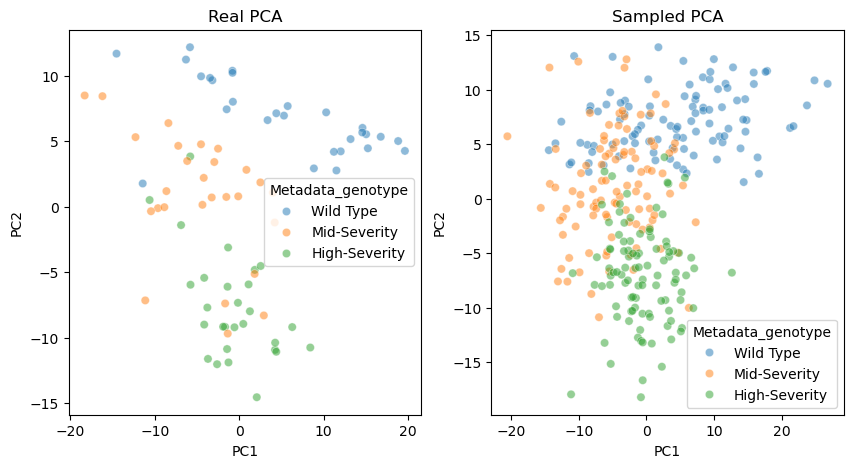

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=custom_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()